In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

# 生成性对抗网络


1. GAN的基本思想
GAN全称对抗生成网络，顾名思义是生成模型的一种，而他的训练则是处于一种对抗博弈状态中的。

2. GAN的基本结构
GAN的主要结构包括一个生成器G（Generator）和一个判别器D（Discriminator）。

在上面的例子中的球员就相当于生成器，我们需要他在球场上能有好的表现。而球员一开始都是初学者，这个时候就需要一个教练员来指导他们训练，告诉他们训练得怎么样，直到真的能够达到上场的标准。而这个教练就相当于判别器。

下面我们举另外一个手写字的例子来进行进一步窥探GAN的结构。
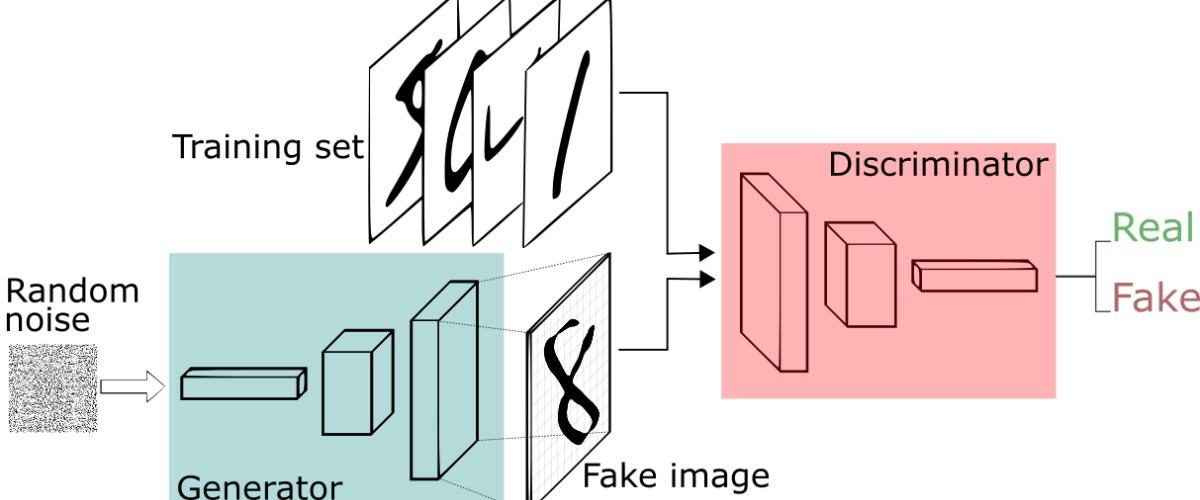

我们现在拥有大量的手写数字的数据集，我们希望通过GAN生成一些能够以假乱真的手写字图片。主要由如下两个部分组成：

定义一个模型来作为生成器（图三中蓝色部分Generator），能够输入一个向量，输出手写数字大小的像素图像。定义一个分类器来作为判别器（图三中红色部分Discriminator）用来判别图片是真的还是假的（或者说是来自数据集中的还是生成器中生成的），输入为手写图片，输出为判别图片的标签。

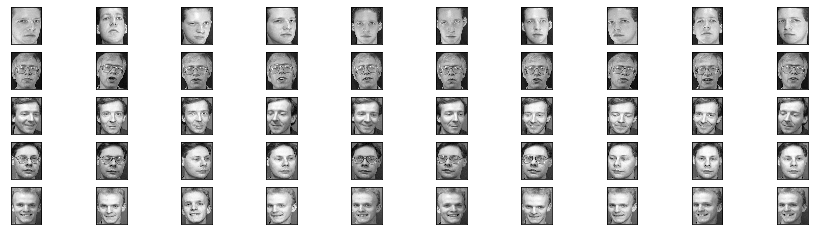

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import metrics 
from numpy import *
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import imageio
import warnings


from sklearn import metrics 
#读取所有训练图片
def read_images():
    faces = []
    dataSetDir = '../face_database/att_face'
    choose = random.permutation(10)+1 #随机排序1-10 (0-9）+1
    for i in range(40):  #有40个人
        people_num = i+1
        for j in range(10):  #每个人有10张脸不同的脸
            filename = imageio.imread(dataSetDir+'/s'+str(people_num)+'/'+str(choose[j])+'.pgm')  #图片地址
            faces.append(filename)
    images,labels = [],[] 
    i = 0
    for face in faces: 
        
        labels.append(int(i/10)+1)
        i = i+1
    return faces,labels

#显示读取的人脸
def show_image(images,i):
    plt.figure(figsize=(15,4))
    for j in range(i*10) :
        plt.subplot(i,10,j+1)
        plt.imshow(images[j],'gray') #灰度
        plt.xticks([]),plt.yticks([])

images,labels = read_images()
show_image(images,5)  #显示部分人脸图片
images = np.array(images)
labels = np.array(labels)

#文件先前生成的图片数据是三维的，要将它改成四维的形式
x_train = images.astype('float32') / 255.
x_train = images.reshape(images.shape + (1,))
y_train = labels.astype('float32') / 255.
y_train = labels.reshape(labels.shape + (1,))



In [3]:
x_train.shape

(400, 112, 92, 1)

生成模型功能：比作是一个样本生成器，输入一个噪声/样本，然后把它包装成一个逼真的样本，也就是输出。

判别模型：比作一个二分类器（如同0-1分类器），来判断输入的样本是真是假。（就是输出值大于0.5还是小于0.5）

# 关于生成器

1. 对于生成器，输入需要一个n维度向量，输出为图片像素大小的图片。因而首先我们需要得到输入的向量。

注意: 这里的生成器可以是任意可以输出图片的模型，比如最简单的全连接神经网络，又或者是反卷积网络等。

这里输入的向量我们将其视为携带输出的某些信息，比如说手写数字为数字几，手写的潦草程度等等。由于这里我们对于输出数字的具体信息不做要求，只要求其能够最大程度与真实手写数字相似（能骗过判别器）即可。所以我们使用随机生成的向量来作为输入即可，这里面的随机输入最好是满足常见分布比如均值分布，高斯分布等。

In [4]:
import keras
from keras import layers
import numpy as np

#attface 中的图片大小为112*92
latent_dim = 112
height = 112 
width = 92
channels = 1

generator_input = keras.Input(shape=(latent_dim,))

# 首先, 将输入转换为16x16 128通道功能图
x = layers.Dense(128 * 56 * 46)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((56, 46, 128))(x)

# 添加卷积层
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 向上采样 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# 添加 conv 层
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

#  生成32x32单通道功能图 
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()



#数据归一化
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 112)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 329728)            37259264  
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 329728)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 56, 46, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 46, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 56, 46, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 112, 92, 256)      1048

# 关于判别器

简单来说就是一个判断 realreal图片和 fakefake图片的二分类模型。
Discriminator是一个卷积的神经网络,所以可以有效的区分图片的相对位置(即注重数据的相关性),但是由于Discriminator只对真实数据奖励(此时的outputoutput大),对伪造的数据惩罚(此时的outputoutput小)

In [5]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# 退出层
x = layers.Dropout(0.4)(x)

# 分类层
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# 为了稳定训练集，我们使用学习率衰减
# 以及优化器中的渐变剪裁（按值）
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 112, 92, 1)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 110, 90, 128)      1280      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 110, 90, 128)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 54, 44, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 54, 44, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 21, 128)       262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 26, 21, 128)       0   

# 生成对抗网络
在训练过程中，生成网络G的目标就是尽量生成真实的图片去欺骗判别网络D。而D的目标就是尽量把G生成的图片和真实的图片分别开来。这样，G和D构成了一个动态的“博弈过程”。

最后博弈的结果是什么？在最理想的状态下，G可以生成足以“以假乱真”的图片G(z)。对于D来说，它难以判定G生成的图片究竟是不是真实的，因此D(G(z)) = 0.5。

这样我们的目的就达成了：我们得到了一个生成式的模型G，它可以用来生成图片。

In [6]:
#  将判别器权重设置为不可训练 
# (只适用于 `gan` 模型)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [7]:
import os
from keras.preprocessing import image
from keras.datasets import mnist


iterations = 2000
batch_size = 20
save_dir = '/home/hy1/fanpengyan/'

# Start training loop
start = 0
for step in range(iterations):
    # 潜在空间中的样本随机点
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 解码成假图像
    generated_images = generator.predict(random_latent_vectors)

    #  把它们和真实的图像结合起来 
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    #  装配识别真假图像的标签 
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    #  添加随机噪音标签
    labels += 0.05 * np.random.random(labels.shape)

    #  训练判别器
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # 潜在空间中的样本随机点
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    #  组装“所有真实的图像” 的标签
    misleading_targets = np.zeros((batch_size, 1))

    #  通过gan模型训练发电机 
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    
    if step % 100 == 0:
        # 保存模型权重
        gan.save_weights('gan.h5')

       
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # 保存生成的图像
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # 保存原始图像
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

/home/hy1/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 0.69217014
adversarial loss at step 0: 0.6478673
discriminator loss at step 100: 0.6840664
adversarial loss at step 100: 0.7029029
discriminator loss at step 200: 0.79288185
adversarial loss at step 200: 3.2561486
discriminator loss at step 300: 0.78956354
adversarial loss at step 300: 0.6957696
discriminator loss at step 400: 0.7514388
adversarial loss at step 400: 0.7030223
discriminator loss at step 500: 0.7109191
adversarial loss at step 500: 0.7823391
discriminator loss at step 600: 0.48609504
adversarial loss at step 600: 2.5803103
discriminator loss at step 700: 0.66389763
adversarial loss at step 700: 0.9235385
discriminator loss at step 800: 0.45749587
adversarial loss at step 800: 1.6632006
discriminator loss at step 900: 0.66978896
adversarial loss at step 900: 0.6604281
discriminator loss at step 1000: 0.6195868
adversarial loss at step 1000: 0.86124486
discriminator loss at step 1100: 0.66227543
adversarial loss at step 1100: 0.88248384
discri

Let's display a few of our fake images:

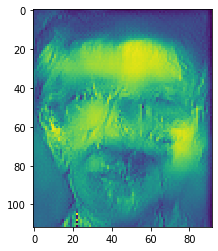

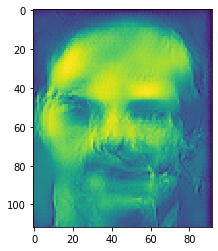

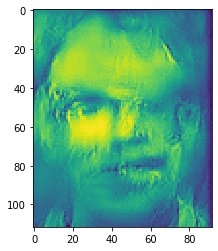

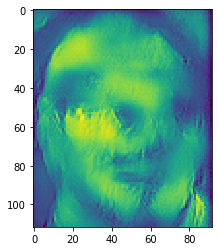

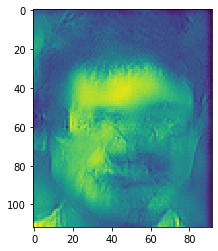

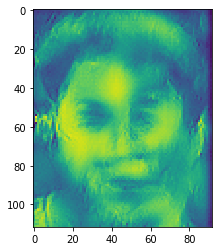

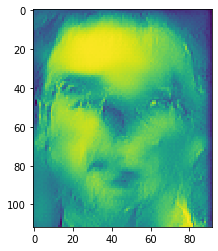

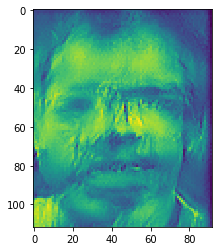

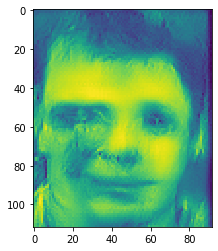

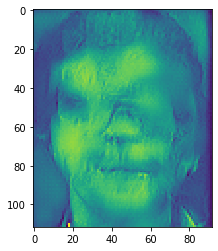

In [8]:
import matplotlib.pyplot as plt

#  潜在空间中的样本随机点 
random_latent_vectors = np.random.normal(size=(10, latent_dim))

#  解码成假图像 
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

Froggy with some pixellated artifacts.